In [67]:
import pandas as pd
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import printable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report, roc_curve
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('data/news_political_dataset.csv')
data.head()

,headline,short_description,is_political
0,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,0
1,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,0
2,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,0
3,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",0
4,Morgan Freeman 'Devastated' That Sexual Harass...,"""It is not right to equate horrific incidents ...",0


In [9]:
def clean_text(text):
    stop_words = stopwords.words('english') + list(printable)
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'([^\s\w]|_)+', ' ', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
    return ' '.join(cleaned_tokens)

In [10]:
data['cleaned_short_description'] = data['short_description'].apply(lambda x: clean_text(str(x)))
data[['short_description', 'cleaned_short_description']].head()

,short_description,cleaned_short_description
0,Of course it has a song.,course song
1,The actor and his longtime girlfriend Anna Ebe...,actor longtime girlfriend anna eberstein tied ...
2,The actor gives Dems an ass-kicking for not fi...,actor give dems as kicking fighting hard enoug...
3,"The ""Dietland"" actress said using the bags is ...",dietland actress said using bag really cathart...
4,"""It is not right to equate horrific incidents ...",right equate horrific incident sexual assault ...


In [15]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_matrix = tfidf_model.fit_transform(data['cleaned_short_description']).todense()
tfidf_df = pd.DataFrame(tfidf_matrix)
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,administration,already,also,always,america,american,another,around,away,...,white,win,without,woman,work,world,would,year,yet,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf_df, data['is_political'], test_size=0.2,
                                                      stratify=data['is_political'])

In [33]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [35]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [40]:
lr_preds = log_reg.predict(X_valid)
nb_preds = nb.predict(X_valid)

In [49]:
confusion_matrix(lr_preds, y_valid)

array([[6507, 2756],
       [ 846, 3792]])

In [42]:
confusion_matrix(nb_preds, y_valid)

array([[6492, 2863],
       [ 861, 3685]])

In [44]:
accuracy_score(lr_preds, y_valid)

0.7408819509387814

In [45]:
accuracy_score(nb_preds, y_valid)

0.7321056039133875

In [57]:
def precision(predictions, y):
    cm = confusion_matrix(predictions, y)
    corrects = cm[0][0] + cm[1][1]
    total = sum(sum(cm))
    return corrects/total

In [58]:
def recall(predictions, y):
    cm = confusion_matrix(predictions, y)
    corrects = cm[0][0] + cm[1][1]
    total = y.shape[0]
    return corrects/total

In [59]:
precision(lr_preds, y_valid)

0.7408819509387814

In [60]:
precision(nb_preds, y_valid)

0.7321056039133875

In [61]:
recall(lr_preds, y_valid)

0.7408819509387814

In [62]:
recall(nb_preds, y_valid)

0.7321056039133875

In [65]:
print(classification_report(lr_preds, y_valid))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      9263
           1       0.58      0.82      0.68      4638

    accuracy                           0.74     13901
   macro avg       0.73      0.76      0.73     13901
weighted avg       0.78      0.74      0.75     13901



In [66]:
print(classification_report(nb_preds, y_valid))

              precision    recall  f1-score   support

           0       0.88      0.69      0.78      9355
           1       0.56      0.81      0.66      4546

    accuracy                           0.73     13901
   macro avg       0.72      0.75      0.72     13901
weighted avg       0.78      0.73      0.74     13901



In [69]:
def get_roc_curve(predictions, y):
    fpr, tpr, threshold = roc_curve(predictions, y)
    _, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, label='ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.show()

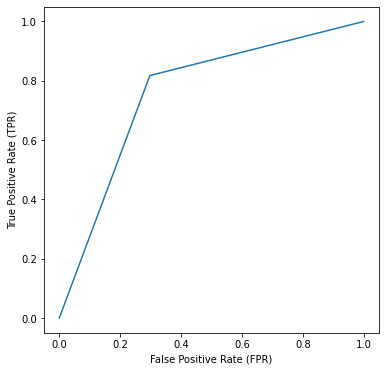

In [70]:
get_roc_curve(lr_preds, y_valid)

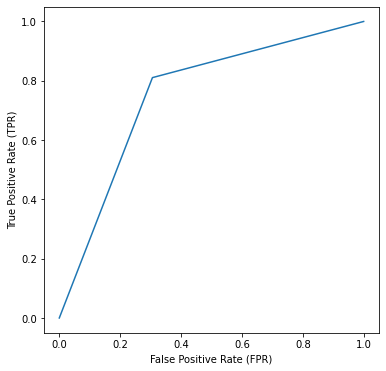

In [71]:
get_roc_curve(nb_preds, y_valid)